In [1]:
import os
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Check if your GPU is requested successfully or not 
assert torch.cuda.device_count() != 0

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# path = "/content/drive/MyDrive/ML_data.json"
path = "data/band/ML_data.json"
repr_path = "mdl_data/representations"
df_in = pd.read_json(path)

# read structure representations
available = sorted(os.listdir(repr_path))
lookup = dict()
for idx, fn in enumerate(available):
    pmg_id = int(fn.split('_')[1])
    lookup[pmg_id] = idx
    
def load_from_id(pmg_id):
    try:
        fn = available[lookup[pmg_id]]
    except KeyError:
        #print(f"Missing representation vector for pymatgen ID: {pmg_id}")
        return float('nan')
    reprpath = os.path.join(repr_path, fn)
    return torch.load(reprpath)

In [5]:
df_in['pmg_ids'] = df_in['filename'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df_in['struct_feat'] = df_in['pmg_ids'].apply(load_from_id)

# split into individual bands
df = pd.concat([df_in] * 10, ignore_index=True)
N = len(df_in.index)
for i in range(10):
    start = 100 * (i%10)
    end = 100 * (i%10) + 100
    df.loc[N*i:N*(i+1), 'PBE'] = df.loc[N*i:N*(i+1), 'PBE'].apply(lambda x: x[start:end])
    df.loc[N*i:N*(i+1), 'HSE'] = df.loc[N*i:N*(i+1), 'HSE'].apply(lambda x: x[start:end])
df = df.sort_values('pmg_ids').reset_index(drop=True)

final_df = df.dropna()
final_df = final_df[final_df['PBE'].apply(len) > 0]

In [6]:
X_data = np.vstack(final_df['PBE'].values)
struct_data = torch.vstack(tuple(final_df['struct_feat'].values))
y_data = np.vstack(final_df['HSE'].values)

In [7]:
X_train, X_test, struct_train, struct_test, y_train, y_test = train_test_split(X_data, struct_data, y_data, test_size=0.1, random_state=0)
X_train, X_val, struct_train, struct_val, y_train, y_val = train_test_split(X_train, struct_train, y_train, test_size=0.11, random_state=0)

In [8]:
# Generate dataset 
class BandstructureDataset(Dataset):
    def __init__(self, X, struct, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.struct = torch.Tensor(struct) # store structure as pytorch Tensor
        self.y = torch.Tensor(y) # store Y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.struct[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

In [9]:
train_data = BandstructureDataset(X_train, struct_train, y_train)# fill in arguments
val_data = BandstructureDataset(X_val, struct_val, y_val)# fill in arguments
test_data = BandstructureDataset(X_test, struct_test, y_test)# fill in arguments

batch_size = 64 # fill in batch size
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(30990, 100)
(3831, 100)
(3870, 100)


In [10]:
include_repr = 1
class BandstructureCNN(torch.nn.Module):
    def __init__(self, channels1=128, kernelsize=8, iosize=100, reprsize=100):
        super().__init__()
        self.n_conv = 3
        self.inputsize = iosize
        self.conv1 = nn.Conv1d(1, channels1, kernel_size=kernelsize)
        self.bn1 = nn.BatchNorm1d(channels1)
        self.conv2 = nn.Conv1d(channels1, channels1, kernel_size=kernelsize)
        self.bn2 = nn.BatchNorm1d(channels1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv1d(channels1, channels1, kernel_size=kernelsize)
        self.bn3 = nn.BatchNorm1d(channels1)
        self.fc1 = nn.Linear((self.inputsize - self.n_conv*(kernelsize - 1)) * channels1 + reprsize, self.inputsize * 2)
        self.fc2 = nn.Linear(self.inputsize * 2, self.inputsize)
        self.fc3 = nn.Linear(self.inputsize * 2, self.inputsize)
        
    def forward(self, x, representation):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x22 = F.relu(self.bn3(self.conv3(x2)))
        x3 = torch.concat((torch.flatten(x22, 1, 2), representation * include_repr), axis=1) # concat repr
        x4 = F.leaky_relu(self.fc1(x3))
        x5 = torch.concat((F.leaky_relu(self.fc2(x4)), x.squeeze()), axis=1) # residual connection
        x6 = self.fc3(x5)
        return x6

device = 'cuda'
model = BandstructureCNN().to(device)
for batch in train_dataloader:
    X, struct, Y = batch
    X = X.to(device)[:,500:600].unsqueeze(1)
    out = model(X, struct)
    print(out.shape)
    break

In [11]:
# device to train on
device = 'cuda:0'
# define your model
model = BandstructureCNN().to(device)

# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

In [12]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model from before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    epoch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        X, struct, y = batch
        X = X.to(device).unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device).unsqueeze(1)
        
        # train your model on each batch here 
        y_pred = model(X, struct)
        
        loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(epoch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model for before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the validation data
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            X, struct, y = batch
            X = X.to(device).unsqueeze(1)
            struct = struct.to(device)
            y = y.to(device).unsqueeze(1)
            
            # validate your model on each batch here 
            y_pred = model(X, struct)

            loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()


In [13]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(201):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    val_loss = validate(model, val_dataloader, device=device) 
    scheduler.step(val_loss)
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    if epoch % 10 == 0:
        print(epoch, epoch_loss, val_loss)
    
    # save model 
    if epoch % 20 == 0:
        torch.save(model.state_dict(), "{}/cnn_calib_{}.pt".format("cnnmodel", epoch))

epoch train loss validation loss
0 0.6735963617403483 0.4942423184712728
10 0.34623946449959403 0.3734257971867919
20 0.26723633075574627 0.36317765098065136
30 0.22964209498664767 0.3293651561563214
40 0.17003863883041537 0.3091824458291133
50 0.1447014546271452 0.32343376372009514
60 0.13971927349177218 0.31040043737739326
70 0.0930901043251464 0.29930768891548115
80 0.08268942891898536 0.28980269382397333
90 0.06651551097093784 0.4829681235055129
100 0.056163381704503725 0.2868156444902221
110 0.05182282806748582 0.2721937766919533
120 0.060410994335471355 0.2540829791376988
130 0.05435311804842396 0.23888922873884438
140 0.04626577991761805 0.24778125444427132
150 0.04484247866749149 0.23265105187892915
160 0.04685880959264396 0.24712123200297356
170 0.031249634735286237 0.23773825721194347
180 0.03768536168889901 0.2557753346549968
190 0.03890973244860922 0.2416262458389004
200 0.03528296661169566 0.31126562021672727


In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model.eval()
Xs = []
y_preds = []
y_trues = []
with torch.no_grad():    
    for batch in test_dataloader: # probably a more efficient way to do this? not sure
        X, struct, y = batch
        Xs.append(X)
        X = X.to(device).unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device).unsqueeze(1)
        y_pred = model(X, struct).detach().cpu().numpy()
        y_true = y.squeeze(1).detach().cpu().numpy()
        y_preds.append(y_pred)
        y_trues.append(y_true)

X = np.concatenate(Xs, axis=0)
y_t = np.concatenate(y_trues, axis=0)
y_p = np.concatenate(y_preds, axis=0)

mean_absolute_error(y_t, y_p)

0.28735158

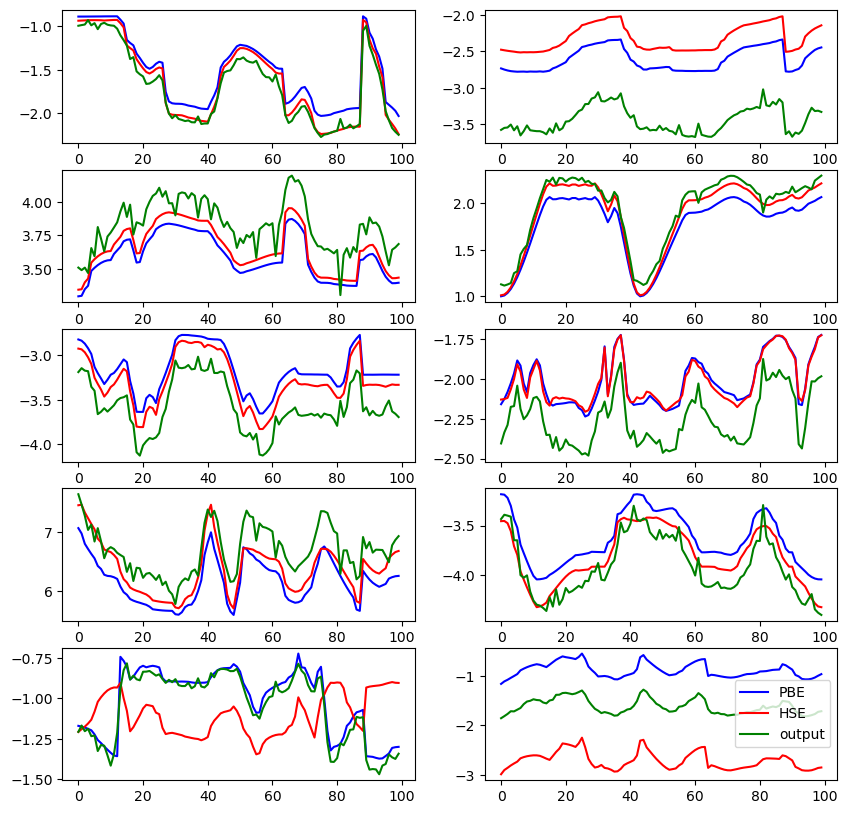

In [19]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
offset=30
for index in range(10):
    X_band = X[index+offset].squeeze()
    y_true_band = y_t[index+offset]
    y_pred_band = y_p[index+offset]
    axes[index%5][index//5].plot(X_band,'b-',label='PBE')
    axes[index%5][index//5].plot(y_true_band, 'r-',label='HSE')
    axes[index%5][index//5].plot(y_pred_band,'g-',label='output')
plt.legend()
plt.show()